In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

In [58]:
#### Importing Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [59]:
##
label = []  
path = []  
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'  

for dir_name, subdirs, filenames in os.walk(fish_dir):  # Correctly unpacking three values
    for filename in filenames:  
        if os.path.splitext(filename)[-1] == '.png':  
            if dir_name.split()[-1] != 'GT':  
                label.append(os.path.split(dir_name)[-1])  
                path.append(os.path.join(dir_name, filename))  

df = pd.DataFrame(columns=['path', 'label'])  
df['path'] = path  
df['label'] = label

In [60]:
##Train-Test Split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Extract labels
y_train = train_data['label'].values
y_test = test_data['label'].values

# Define features (X_train and X_test)
X_train = train_data['path'].values  
X_test = test_data['path'].values      
print(f"Train Set Size : {len(train_data)}")
print(f"Test Set Size: {len(test_data)}")

Train Set Size : 7200
Test Set Size: 1800


In [61]:
train_data.head()

,path,label
904,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
7510,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream
8730,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
4340,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout
3241,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet


In [62]:
## One Hot Encoding
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False)  

y_train_encoded = ohe.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = ohe.transform(y_test.reshape(-1, 1))

print(f"Training labels (One-Hot Encoded): \n{y_train_encoded[:5]}")
print(f"Test labels (One-Hot Encoded): \n{y_test_encoded[:5]}")

Training labels (One-Hot Encoded): 
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Test labels (One-Hot Encoded): 
[[0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [63]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_and_preprocess_images(file_paths, target_size=(64, 64)):
    images = []
    for file_path in file_paths:
        img = load_img(file_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

# Load images for training and testing
X_train_images = load_and_preprocess_images(X_train)  # Load images for training
X_test_images = load_and_preprocess_images(X_test)    # Load images for testing


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3))) 
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,425,609 (24.51 MB)

 Trainable params: 6,425,609 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
MLP = model.fit(X_train_images, y_train_encoded, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.1502 - loss: 3.5802 - val_accuracy: 0.2549 - val_loss: 2.0823
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2067 - loss: 2.0328 - val_accuracy: 0.3194 - val_loss: 1.9432
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1796 - loss: 2.0653 - val_accuracy: 0.3056 - val_loss: 1.9521
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2174 - loss: 2.0192 - val_accuracy: 0.2583 - val_loss: 1.9280
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.1715 - loss: 2.0569 - val_accuracy: 0.2722 - val_loss: 1.8932
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2151 - loss: 1.9940 - val_accuracy: 0.2819 - val_loss: 1.8968
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2143 - loss: 1.9676 - val_accuracy: 0.3403 - val_loss: 1.7333
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2411 - loss: 1.9242 - val_accu

In [67]:
from sklearn.metrics import f1_score, recall_score, precision_score, cohen_kappa_score

# Predict on the test data
y_pred_probs = model.predict(X_test_images) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_test_labels = np.argmax(y_test_encoded, axis=1)  

# Compute metrics
f1 = f1_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
precision = precision_score(y_test_labels, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test_labels, y_pred)
test_loss, test_accuracy = model.evaluate(X_test_images, y_test_encoded)

# Print the results
print (f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3773 - loss: 1.6683
Test Accuracy: 0.3778
F1 Score: 0.3153
Recall: 0.3778
Precision: 0.3870
Cohen's Kappa Score: 0.3000


**Hyperparameter Optimization and Final Model Evaluation**

In [75]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

def create_model(learning_rate=0.01, num_layers=1, units=32, dropout_rate=0.0):
    model = Sequential()
    model.add(Flatten(input_shape=(64, 64, 3)))  
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hiperparametreler için grid tanımı
param_grid = {
    'learning_rate': [0.001, 0.01],
    'num_layers': [1, 2],
    'units': [16,32,48, 64],
    'dropout_rate': [0.0,0.25,0.45, 0.5]
}

best_model = None
best_accuracy = 0
best_params = {}

for learning_rate in param_grid['learning_rate']:
    for num_layers in param_grid['num_layers']:
        for units in param_grid['units']:
            for dropout_rate in param_grid['dropout_rate']:
                model = create_model(learning_rate, num_layers, units, dropout_rate)
                history = model.fit(X_train_images, y_train_encoded, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

                # Modeli değerlendirme
                y_pred = model.predict(X_test_images)
                y_pred_labels = np.argmax(y_pred, axis=1)
                y_test_labels = np.argmax(y_test_encoded, axis=1)

                accuracy = accuracy_score(y_test_labels, y_pred_labels)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model
                    best_params = {
                        'learning_rate': learning_rate,
                        'num_layers': num_layers,
                        'units': units,
                        'dropout_rate': dropout_rate
                    }


y_pred_best = best_model.predict(X_test_images)
y_pred_best_labels = np.argmax(y_pred_best, axis=1)

f1 = f1_score(y_test_labels, y_pred_best_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_best_labels, average='weighted')
precision = precision_score(y_test_labels, y_pred_best_labels, average='weighted')


print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: {best_params}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━

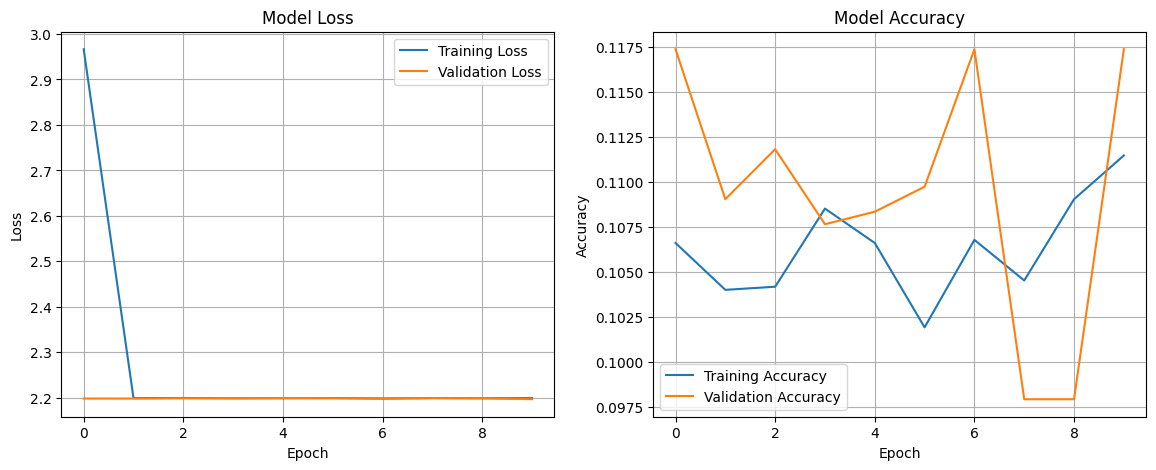

In [77]:
import matplotlib.pyplot as plt


# Plotting training loss and accuracy
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.show()